# Step 1: Toy Problem
This notebook covers the basic implementation for our toy problem, we designed it with 4 qubits since it is a small enough circuit width to function as a building block, and also has enough qubits to run trotter step evolution.

In [1]:
from classiq import *
from classiq.execution import ExecutionPreferences
from math import pi

In [2]:
TROTTER_STEPS = 1
THETA_H = 0
SHOTS = 100

Each type of connection between the qubits will have a certain type, representing the four different permutations of the S and CX gates. The connection with a single line will be covered in the first layer of the Trotter step, and connection with 2 lines will be covered in the second layer.

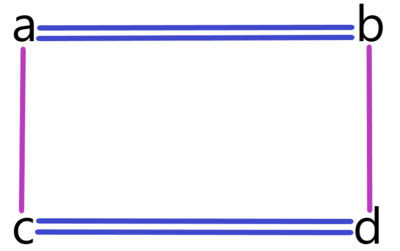


Here, we implemented the $RZZ(-\pi/2)$ gate from the paper using inverse S gates and control-not gates, the only difference being the square-root Y gate, which we evaluated to be the $RY(\pi/2)$ gate.

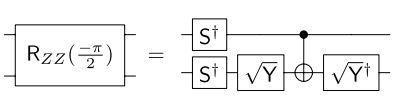

RZZ Gate.
From “Evidence for the utility of quantum computing before fault tolerance”, by Kim Youngseok, Andrew Eddings, et al., 2023, Nature, Vol 618, pg. 501, https://www.nature.com/articles/s41586-023-06096-3


In [3]:
@qfunc
def trotter_step(a: QBit, b: QBit, c: QBit, d: QBit):
    # apply a rotation over the X axis on all qubits with an angle of theta_h
    RX(THETA_H, a)
    RX(THETA_H, b)
    RX(THETA_H, c)
    RX(THETA_H, d)

    # first ZZ layer
    invert(lambda: S(a))
    invert(lambda: S(b))
    within_apply(compute=lambda: RY(pi/2 ,b), action=lambda: CX(a, b))

    invert(lambda: S(c))
    invert(lambda: S(d))
    within_apply(compute=lambda: RY(pi/2 ,d), action=lambda: CX(c, d))

    # second ZZ layer
    invert(lambda: S(a))
    invert(lambda: S(c))
    within_apply(compute=lambda: RY(pi/2 ,c), action=lambda: CX(a, c))

    invert(lambda: S(b))
    invert(lambda: S(d))
    within_apply(compute=lambda: RY(pi/2 ,d), action=lambda: CX(b, d))


@qfunc
def trotterized_time_evolution(a: QBit, b: QBit, c: QBit, d: QBit):
    for _ in range(TROTTER_STEPS):
      trotter_step(a, b, c, d)

@qfunc
def main(expectation_value: Output[QBit]):
    # initialize the 4 qubits
    a = QBit("a")
    b = QBit("b")
    c = QBit("c")
    d = QBit("d")

    allocate(1, a)
    allocate(1, b)
    allocate(1, c)
    allocate(1, d)

    # setup for measurement of the expectation value
    allocate(1, expectation_value)

    within_apply(lambda: hadamard_transform(expectation_value), lambda: control(expectation_value, lambda: trotterized_time_evolution(a, b, c, d)))


In [4]:
# Gets the counts of measuring the qubits in their respective states
def synthesize_execute(shots: int):
    quantum_model = set_execution_preferences(
    create_model(main),
    ExecutionPreferences(num_shots=shots),
    )

    quantum_program = synthesize(quantum_model)
    job = execute(quantum_program)
    results = job.result()[0].value.parsed_counts

    return results

# Evaluates the real part of expectation value
def evaluate_real_part(shots):
    print(f"Executing with {shots} shots...")
    result = synthesize_execute(shots)

    if result[0].state["expectation_value"] == 0:
        prob = result[0].shots / shots
    else:
        prob = result[1].shots / shots

    print(f"Measured 0 with probability of {prob*100:.3f}%")

    return 2*prob - 1

In [6]:
# evaluate and print results
value = evaluate_real_part(SHOTS)
print("Expectation value", value)

Executing with 100 shots...
Measured 0 with probability of 100.000%
Expectation value 1.0


Show diagram of the quantum circuit

In [ ]:
qprog = synthesize(create_model(main))
show(qprog)